In [1]:
!pip install nibabel

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from scipy.ndimage import gaussian_filter
import numpy as np
from skimage.transform import resize, rotate
from PIL import Image
import nibabel as nib

In [3]:
%matplotlib inline

In [4]:
# test_img_path = "image_files/test_image/presentation_mri.jpg"

In [5]:
# from PIL import Image
# test_img = Image.open(test_img_path)
# test_img.show()

# Rotation & blur

In [6]:
# import skimage
# import numpy as np

# rotated_array = skimage.transform.rotate(np.array(test_img),5, preserve_range=True)
# rotated_img = Image.fromarray(np.uint8(rotated_array))
# rotated_img.show()

In [7]:
# blurred_array = skimage.filters.gaussian(np.array(test_img),sigma=2,preserve_range=True)
# blurred_img = Image.fromarray(np.uint8(blurred_array))
# blurred_img.show()

# Generating augmented frames for 2D image

In [8]:
def imgage_path_to_array(image_path):
    if '.dcm' in image_path:
        dicom_data = pydicom.dcmread(image_path)
        return dicom_data.pixel_array
    elif '.nii.gz' in image_path:
        nifti_data = nib.load(image_path)
        return nifti_data.get_fdata()
    else:
        return np.array(Image.open(image_path))

In [9]:
# def save_frame(frame, frame_number, save_frame_path, frame_name):
#     frame_path = save_frame_path + f"{frame_name}_{frame_number:02d}.png"
#     Image.fromarray((frame * 255).astype(np.uint8)).save(frame_path)
#     img = plt.imread(frame_path)
#     return img

In [10]:
# def calculate_max_size(image_array, max_elongation):
#     max_height = int(image_array.shape[0] * (1 + max_elongation))
#     max_width = int(image_array.shape[1] * (1 + 0.25 * max_elongation))
#     return max_height, max_width

In [11]:
# def generate_random_factors(num_frames, random=True):
#     if random:
#         rnd_factors = {
#             "rnd_me": np.random.rand() - 0.5,
#             "rnd_ts": np.random.randint(0, int(num_frames * 0.15)) - int(num_frames * 0.15 * 0.5),
#             "rnd_blur_size": (np.random.rand() - 0.5) * 2,
#             "rnd_blur_shift": (np.random.rand() - 0.5) * np.pi
#         }
#     else:
#         rnd_factors = {"rnd_me": 0, "rnd_ts": 0, "rnd_blur_size": 0, "rnd_blur_shift": 0}
#     return rnd_factors

# def apply_random_factors(max_elongation, blur_size, rnd_factors):
#     max_elongation += rnd_factors["rnd_me"] * 0.015
#     blur_size += rnd_factors["rnd_blur_size"]
#     blur_shift = rnd_factors["rnd_blur_shift"]
#     return max_elongation, blur_size, blur_shift

In [12]:
# def generate_frame(image_array, frame_number, num_frames, max_elongation, blur_size, blur_shift, max_size):
#     t = np.linspace(0, 2 * np.pi, num_frames)[frame_number]
#     elongation_factor_height = 1.0 + max_elongation * np.sin(t)
#     elongation_factor_width = 1.0 + max_elongation * np.sin(t) * 0.25
#     output_image = resize(image_array, (int(image_array.shape[0] * elongation_factor_height),
#                                         int(image_array.shape[1] * elongation_factor_width)),
#                           anti_aliasing=True, mode='reflect')
    
#     sigma = 0 + (blur_size * np.abs(np.sin(t + blur_shift)))
#     output_image = gaussian_filter(output_image, sigma=(sigma, 0, 0))

#     background = np.zeros((max_size[0], max_size[1], 3))
#     top_offset = max_size[0] - output_image.shape[0]
#     left_offset = int((max_size[1] - output_image.shape[1]) / 2)
#     background[top_offset:top_offset + output_image.shape[0], left_offset:left_offset + output_image.shape[1]] = output_image[..., :3]
#     return background

In [13]:
# def generate_effect_frames_for_animation(image_path, save_frame_path,frame_name = "frame", num_frames=10, max_elongation=0.025, blur=True, random=False):
    
#     # get array from img path
#     image_array = imgage_path_to_array(image_path)

#     blur_size = 3
#     blur_shift = 0

    
#     #generate random factor for amplitude, time scale, blur 
#     rnd_factors = generate_random_factors(num_frames, random)
#     max_elongation, blur_size, blur_shift = apply_random_factors(max_elongation, blur_size, rnd_factors)
    
    
#     # Calculate the maximum elongation size of the output image (biggest elongations)
#     max_height, max_width = calculate_max_size(image_array, max_elongation)
#     max_size = (max_height, max_width)

#     frames = []
#     for frame_number in range(num_frames):
#         background = generate_frame(image_array, frame_number, num_frames, max_elongation, blur_size, blur_shift, max_size)
#         img = save_frame(background, frame_number, save_frame_path, frame_name)
#         frames.append([img])

#     return frames


# Save frames, and display as animation

In [14]:
# def frames_to_animation():
#     pass

In [15]:
# num_frames = 10
# test_img_path = "image_files/test_image/presentation_mri.jpg"
# save_frame_path = "image_files/test_image/frames/" #needs '/' at the end; TODO: add fix in function
# # test_img_path = "image_files/test_patient/p_001.nii.gz" #TODO: add .nii.gz compatibility
# # save_frame_path = "image_files/test_patient/frames/" #needs '/' at the end TODO: add fix in function

# frame_name = "frame"

# # Generate frames with effects for animation
# generate_effect_frames_for_animation(test_img_path,save_frame_path,frame_name,num_frames=num_frames, random=True)


# # Set up the figure
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.axis('off')  # Turn off axes

# # Load all the saved frames
# frames = []  # To hold the images for animation
# for i in range(0, num_frames):
#     frame_path = save_frame_path+f"{frame_name}_{i:02d}.png"
#     frame = Image.open(frame_path)
#     frames.append([plt.imshow(frame, animated=True)])

# # Create the animation
# ani = animation.ArtistAnimation(fig, frames, interval=(2000/num_frames), blit=True, repeat_delay=1000)
# ani.save('animation.gif', writer='pillow')
# # Show the animation
# plt.close()  # Close the static figure to prevent it from displaying
# # ani  # This will show the animation in the output cell
# %matplotlib inline
# HTML(ani.to_jshtml())

In [16]:
# import skimage
# import numpy as np

# def rotate_image(img, angle):
#     #assumes `img` is loaded with PIL's `Image` function 
#     rotated_array = skimage.transform.rotate(np.array(img),angle, preserve_range=True)
#     return Image.fromarray(np.uint8(rotated_array))

# def flip_image_lr(img):
#     #assumes `img` is loaded with PIL's `Image` function 
#     rotated_array = skimage.transform.rotate(np.array(img),0, preserve_range=True)
#     return Image.fromarray(np.fliplr(np.uint8(rotated_array)))

# rotated_image = rotate_image(test_img, 5)
# rotated_image.show()
# flipped_image = flip_image_lr(test_img)
# flipped_image.show()
# print(type(flipped_image))
# print(type(test_img))


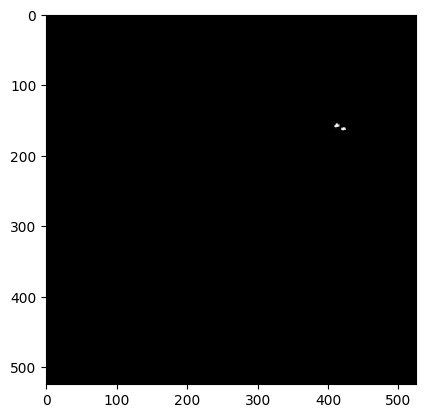

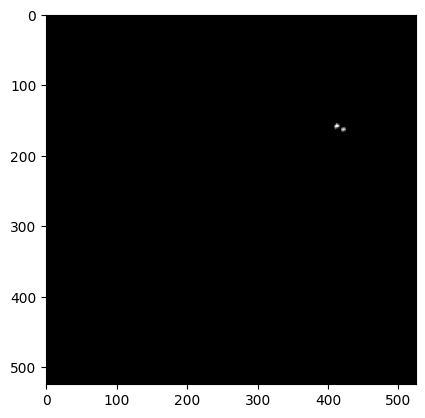

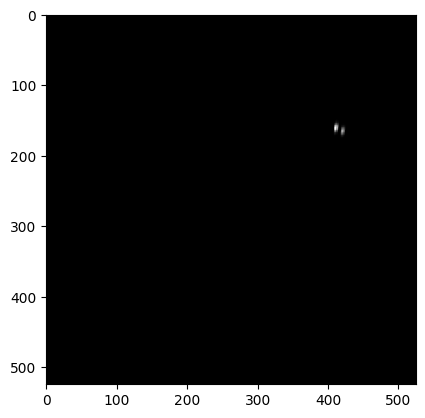

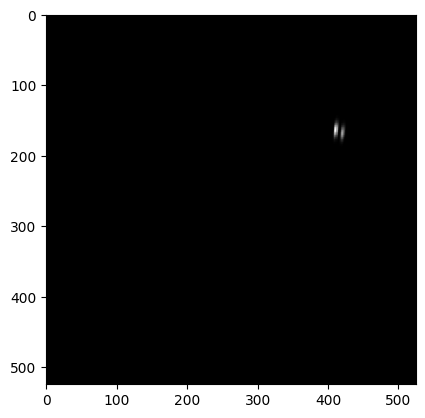

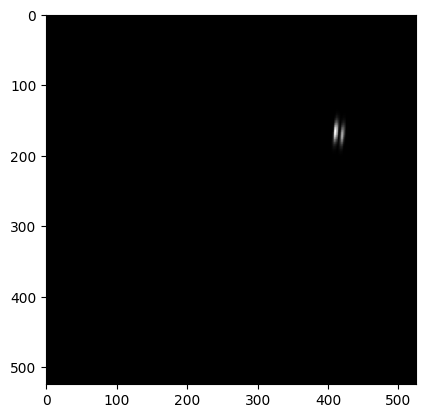

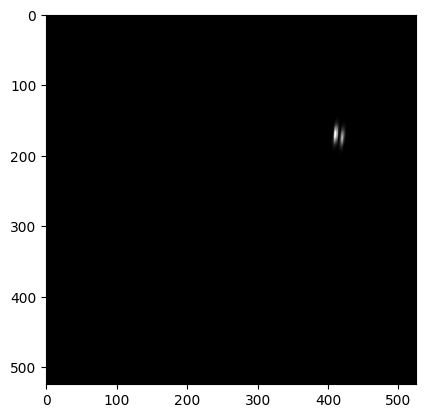

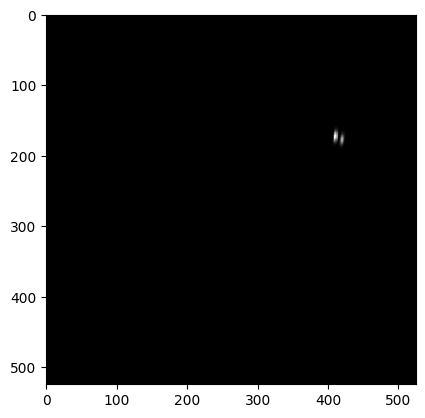

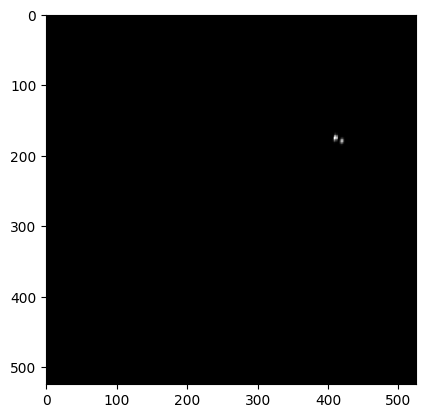

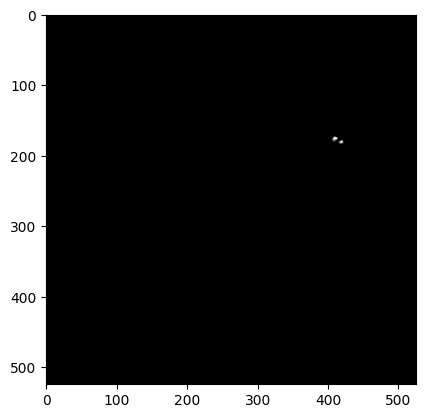

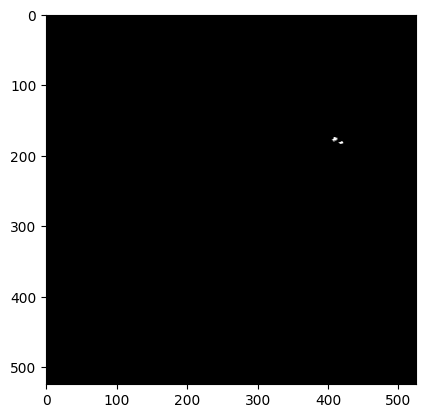

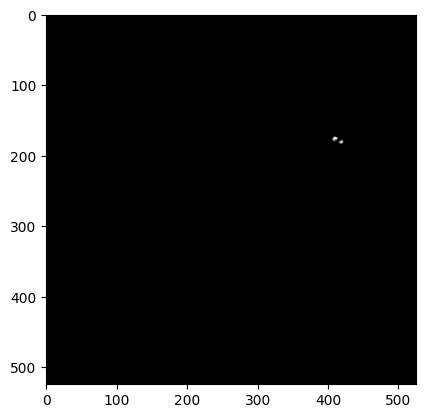

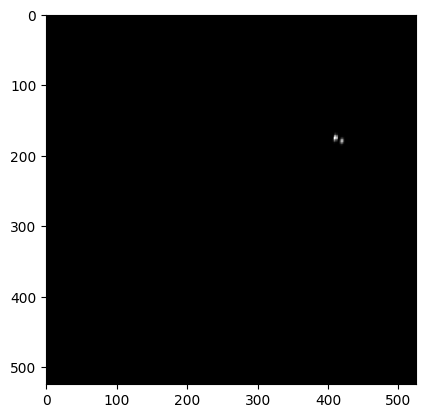

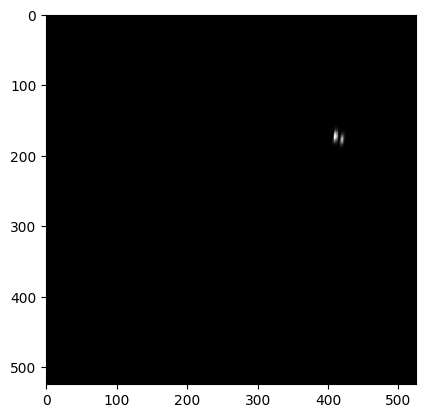

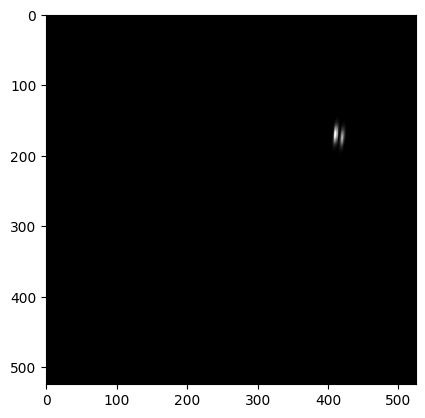

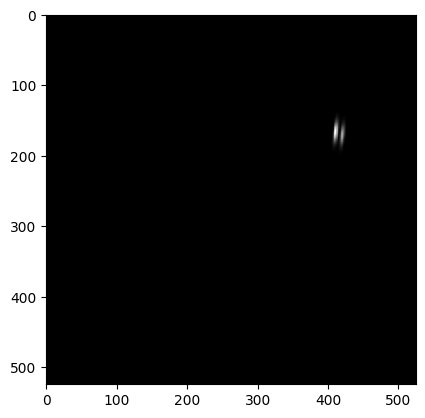

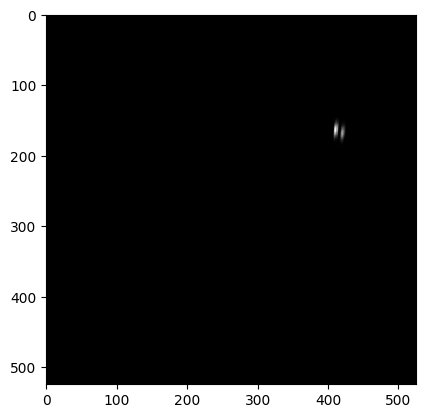

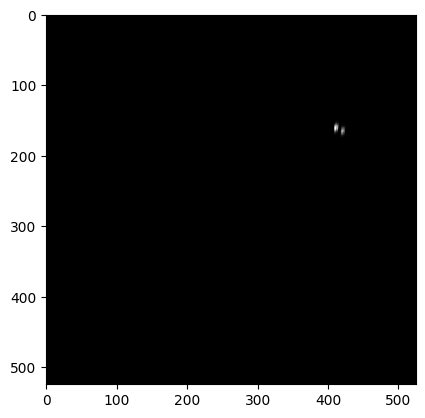

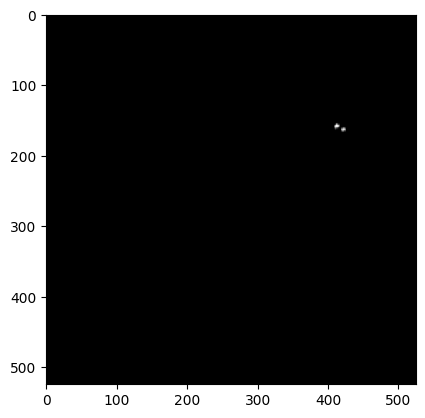

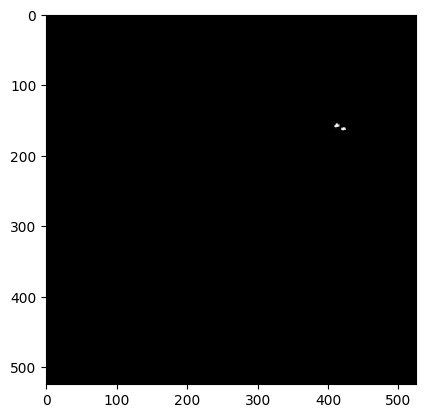

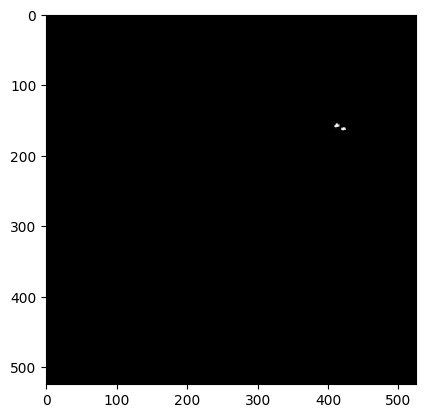

(5, 20, 64, 64, 1)


In [88]:
import skimage
import numpy as np
import imageio
import random
from PIL import Image
import skimage.transform
from skimage.transform import resize, rotate
import numpy as np
from skimage.transform import resize
from scipy.ndimage import gaussian_filter
import numpy as np
from skimage.transform import resize
from scipy.ndimage import gaussian_filter

def rotate_arr(arr, angle):
    return rotate(arr, angle, preserve_range=True, mode='edge')

def flip_array_lr(arr):
    return np.fliplr(arr)

def compress_array(arr, compression_factor_height,compression_factor_width):
    return resize(arr, (int(arr.shape[0] * compression_factor_height),
                                int(arr.shape[1] * compression_factor_width),
                                int(arr.shape[2])), anti_aliasing=True, mode='reflect')

def plot_arr(arr, hide_axis=False):
    plt.imshow(arr, cmap='gray', interpolation='nearest')
    if hide_axis:
        plt.axis('off')
    plt.show()


def generate_frame(image_array, t, max_elongation, width_weight, blur_size):

    elongation_factor_height = 1.0 + max_elongation * t
    elongation_factor_width = 1.0 + max_elongation * width_weight * t
    resized_image = resize(image_array, (int(image_array.shape[0] * elongation_factor_height),
                                        int(image_array.shape[1] * elongation_factor_width),
                                       image_array.shape[2]),
                          anti_aliasing=True, preserve_range=True,mode='symmetric')
    # print("Data type:", resized_image.dtype)
    # print("Min value:", resized_image.min())
    # print("Max value:", resized_image.max())
    
    sigma = blur_size * (1-np.abs(t))
    output = gaussian_filter(resized_image, sigma=(sigma, sigma*width_weight, 0))

    return output

    

def place_image_on_black_frame(base_image, resized_image, black_frame_size):
    """ Place the resized image on a black frame aligned at the bottom and centered horizontally. """
    resized_height = resized_image.shape[0] 
    resized_width = resized_image.shape[1]
    
    black_image = np.zeros(black_frame_size)#, dtype=base_image.dtype)
    vertical_start = black_frame_size[0] - resized_height
    horizontal_start = (black_frame_size[1] - resized_width) // 2
    black_image[vertical_start:vertical_start + resized_height, horizontal_start:horizontal_start + resized_width, :] = resized_image#.astype(base_image.dtype)
    # plot_arr(black_image)
    return black_image
    

# Function to normalize a sequence of frames to a specific size
def normalize_sequence(frames, target_shape):
    normalized_frames = [resize(frame, (target_shape), anti_aliasing=True) for frame in frames]
    return normalized_frames

def average_third_dimension(array):
    if array.shape[-1] > 3:
        averaged_array = np.mean(array[:,:,0:3], axis=2, keepdims=True)
        return averaged_array
    # Calculate the average along the third dimension
    averaged_array = np.mean(array, axis=2, keepdims=True)
    return averaged_array


# test_img_path = "image_files/test_image/presentation_mri.jpg"
test_img_path = "../segmentation_extraction/extracted_slices/slice_0.png"
original_image = np.array(Image.open(test_img_path))



n = 3  # Number of sequences
m = 20  # Number of frames per sequence

# Process and store sequences
sequences = []
for i in range(n):
    main_sequence_image = original_image
    # Create frames for each sequence
    frames = []
    # generating randomness
    time_wave_start = 2 * (np.random.rand() - 0.5)
    time_wave_end = (2 + time_wave_start) + 2*(np.random.rand() - 0.5)
    time_wave = np.sin(np.linspace(time_wave_start*np.pi, time_wave_end * np.pi, m))
    max_elongation = np.random.rand() * 0.3 
    width_weight = np.random.rand() * 0.3 
    blur_amout = np.random.rand() * 10 * 5 
    flip_or_not = np.round(np.random.rand())
    rot_angle = (np.random.rand()-0.5)*2 * 5
    
    for j in range(m):
        
        edited_array = generate_frame(main_sequence_image, time_wave[j], max_elongation, width_weight, blur_amout)
        
        black_frame_size = (int(main_sequence_image.shape[0] * (1+max_elongation)),
                            int(main_sequence_image.shape[1] * (1+max_elongation)),
                            main_sequence_image.shape[2])
        
        frame = place_image_on_black_frame(main_sequence_image, edited_array, black_frame_size)
        frame = average_third_dimension(frame)

        if flip_or_not == 1:
            frame = flip_array_lr(frame)
        frame = rotate_arr(frame, rot_angle)
        frames.append(frame)
        if i==0:
            plot_arr(frame)

        

    target_shape = (64, 64, 1)
    reshaped_frames = normalize_sequence(frames, target_shape)
    # `sequences` now contains all the processed and normalized frames.
    sequences.append(reshaped_frames)



print(np.array(sequences).shape)




In [ ]:
import os
import skimage
import numpy as np
from PIL import Image
from skimage.transform import resize, rotate
from scipy.ndimage import gaussian_filter

def rotate_arr(arr, angle):
    return rotate(arr, angle, preserve_range=True, mode='edge')

def flip_array_lr(arr):
    return np.fliplr(arr)

def compress_array(arr, compression_factor_height, compression_factor_width):
    return resize(arr, (int(arr.shape[0] * compression_factor_height),
                        int(arr.shape[1] * compression_factor_width),
                        int(arr.shape[2])), anti_aliasing=True, mode='reflect')

def generate_frame(image_array, t, max_elongation, width_weight, blur_size):
    elongation_factor_height = 1.0 + max_elongation * t
    elongation_factor_width = 1.0 + max_elongation * width_weight * t
    resized_image = resize(image_array, (int(image_array.shape[0] * elongation_factor_height),
                                         int(image_array.shape[1] * elongation_factor_width),
                                         image_array.shape[2]),
                           anti_aliasing=True, preserve_range=True, mode='symmetric')
    sigma = blur_size * (1 - np.abs(t))
    output = gaussian_filter(resized_image, sigma=(sigma, sigma * width_weight, 0))
    return output

def place_image_on_black_frame(base_image, resized_image, black_frame_size):
    resized_height = resized_image.shape[0] 
    resized_width = resized_image.shape[1]
    black_image = np.zeros(black_frame_size)
    vertical_start = black_frame_size[0] - resized_height
    horizontal_start = (black_frame_size[1] - resized_width) // 2
    black_image[vertical_start:vertical_start + resized_height, horizontal_start:horizontal_start + resized_width, :] = resized_image
    return black_image

def normalize_sequence(frames, target_shape):
    return [resize(frame, target_shape, anti_aliasing=True) for frame in frames]

def average_third_dimension(array):
    return np.mean(array[:, :, :3], axis=2, keepdims=True) if array.shape[-1] > 3 else np.mean(array, axis=2, keepdims=True)

directory_path = "../segmentation_extraction/extracted_slices"
n = 3  # Number of sequences per image
m = 20  # Number of frames per sequence
all_sequences = []

# Process each image in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.png'):  # Ensuring only image files are processed
        file_path = os.path.join(directory_path, filename)
        original_image = np.array(Image.open(file_path))

        sequences = []
        for i in range(n):
            frames = []
            time_wave_start = 2 * (np.random.rand() - 0.5)
            time_wave_end = (2 + time_wave_start) + 2 * (np.random.rand() - 0.5)
            time_wave = np.sin(np.linspace(time_wave_start * np.pi, time_wave_end * np.pi, m))
            max_elongation = np.random.rand() * 0.3
            width_weight = np.random.rand() * 0.3
            blur_amount = np.random.rand() * 50
            flip_or_not = np.round(np.random.rand())
            rot_angle = (np.random.rand() - 0.5) * 10

            for j in range(m):
                edited_array = generate_frame(original_image, time_wave[j], max_elongation, width_weight, blur_amount)
                black_frame_size = (int(original_image.shape[0] * (1 + max_elongation)), int(original_image.shape[1] * (1 + max_elongation)), original_image.shape[2])
                frame = place_image_on_black_frame(original_image, edited_array, black_frame_size)
                frame = average_third_dimension(frame)
                if flip_or_not == 1:
                    frame = flip_array_lr(frame)
                frame = rotate_arr(frame, rot_angle)
                frames.append(frame)

            target_shape = (64, 64, 1)
            reshaped_frames = normalize_sequence(frames, target_shape)
            sequences.append(reshaped_frames)
        
        all_sequences.append(sequences)  # Append sequences of each image to the main list

# Save all sequences to a .npy file
np.save('output_sequences.npy', np.array(all_sequences))
print("Sequences saved successfully.")


In [ ]:
 np.array(all_sequences).shape